# Packages 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

# Data 

In [3]:
Nout = 100000 # number of out-of-sample scenarios
Nin = 5000 # number of in-sample scenarios
Ns = 5 # number of idiosyncratic scenarios for each systemic
C = 8 # number of credit states
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0] # ID
driver = instr_data[:, 1] # credit driver
beta = instr_data[:, 2] # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3] # expected recovery rate
value = instr_data[:, 4] # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C] # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns
K = instr_data.shape[0] # number of CPs

In [4]:
df1 = pd.read_csv('instrum_data.csv', header=None)
df1.columns = [
    "Counterparty ID", "Credit Risk Driver",
    "Beta (Sensitivity to Credit Driver)", "Expected Recovery Rate", "Value",
    "Pr(default)", "Pr(CCC)", "Pr(B)", "Pr(BB)", "Pr(BBB)", "Pr(A)", "Pr(AA)",
    "Pr(AAA)", "L(default)", "L(CCC)", "L(B)", "L(BB)", "L(BBB)", "L(A)",
    "L(AA)", "L(AAA)", "Market Returns"
]
df1.head().style.format({
    "Beta (Sensitivity to Credit Driver)": "{:.4f}",
    "Expected Recovery Rate": "{:.2f}",
    "Value": "{:,.0f}",
    "Pr(default)": "{:.4f}",
    "Pr(CCC)": "{:.4f}",
    "Pr(B)": "{:.4f}",
    "Pr(BB)": "{:.4f}",
    "Pr(BBB)": "{:.4f}",
    "Pr(A)": "{:.4f}",
    "Pr(AA)": "{:.4f}",
    "Pr(AAA)": "{:.4f}",
    "L(default)": "{:,.0f}",
    "L(CCC)": "{:,.0f}",
    "L(B)": "{:,.0f}",
    "L(BB)": "{:,.0f}",
    "L(BBB)": "{:,.0f}",
    "L(A)": "{:,.0f}",
    "L(AA)": "{:,.0f}",
    "L(AAA)": "{:,.0f}",
    "Market Returns": "{:.4%}"
}).hide_index().set_table_styles([{
    'selector':
    '',
    'props': [('border', '5px solid black'), ('font-size', '15px')]
}, {
    'selector': 'td',
    'props': 'text-align: center;'
}])

Counterparty ID,Credit Risk Driver,Beta (Sensitivity to Credit Driver),Expected Recovery Rate,Value,Pr(default),Pr(CCC),Pr(B),Pr(BB),Pr(BBB),Pr(A),Pr(AA),Pr(AAA),L(default),L(CCC),L(B),L(BB),L(BBB),L(A),L(AA),L(AAA),Market Returns
1,1,0.5568,0.62,"10,255,741",0.0002,0.0001,0.0013,0.0050,0.0507,0.9183,0.0239,0.0005,"10,255,741","503,640","201,280","59,625","11,484",0,-500,"-1,500",7.0315%
2,2,0.5568,0.60,"9,997,200",0.0002,0.0001,0.0013,0.0050,0.0507,0.9183,0.0239,0.0005,"9,997,200","939,798","398,956","124,925","23,465",0,"-3,250","-5,000",7.0435%
3,3,0.5568,0.70,"1,990,657",0.0127,0.0055,0.0705,0.8512,0.0545,0.0050,0.0005,0.0001,"1,990,657","127,827","49,364",0,"-22,345","-28,192","-29,480","-29,884",10.4110%
4,3,0.5568,0.58,"37,524,383",0.0127,0.0055,0.0705,0.8512,0.0545,0.0050,0.0005,0.0001,"37,524,383","2,820,870","1,006,907",0,"-405,563","-496,704","-517,622","-523,328",10.4342%
5,4,0.5568,0.54,"4,997,650",0.0018,0.0016,0.0080,0.0488,0.8849,0.0520,0.0024,0.0005,"4,997,650","459,148","188,151","50,840",0,"-11,759","-13,387","-14,264",8.2614%


The number and type of Credit Risk Driver

In [5]:
df1["Credit Risk Driver"].value_counts()

46    6
49    4
47    4
18    4
16    4
41    3
15    3
45    3
43    3
42    3
22    3
30    2
32    2
34    2
26    2
36    2
37    2
38    2
44    2
48    2
24    2
50    2
13    2
3     2
7     2
20    2
8     2
19    2
9     2
17    2
21    2
12    2
40    1
4     1
5     1
6     1
10    1
11    1
23    1
39    1
14    1
35    1
33    1
31    1
29    1
28    1
27    1
2     1
25    1
1     1
Name: Credit Risk Driver, dtype: int64

For every id, there are 8 credit transition probabilities. (Pr(XX), col:5:(5 + 8))


In [6]:
print(instr_data[:, 5:(5 + C)].shape)
instr_data[:, 5:(5 + C)][:2]

(100, 8)


array([[2.000e-04, 1.000e-04, 1.300e-03, 5.000e-03, 5.070e-02, 9.183e-01,
        2.390e-02, 5.000e-04],
       [2.000e-04, 1.000e-04, 1.300e-03, 5.000e-03, 5.070e-02, 9.183e-01,
        2.390e-02, 5.000e-04]])

For every id , there are 8 credit exposures (losses or gains) associated with each future credit state. (L(XX),col:5 + 8:5 + 2 * 8)

In [7]:
print(exposure.shape)
exposure[:2]

(100, 8)


array([[ 1.0255741e+07,  5.0364000e+05,  2.0128000e+05,  5.9625000e+04,
         1.1484000e+04,  0.0000000e+00, -5.0000000e+02, -1.5000000e+03],
       [ 9.9972000e+06,  9.3979800e+05,  3.9895600e+05,  1.2492500e+05,
         2.3465000e+04,  0.0000000e+00, -3.2500000e+03, -5.0000000e+03]])

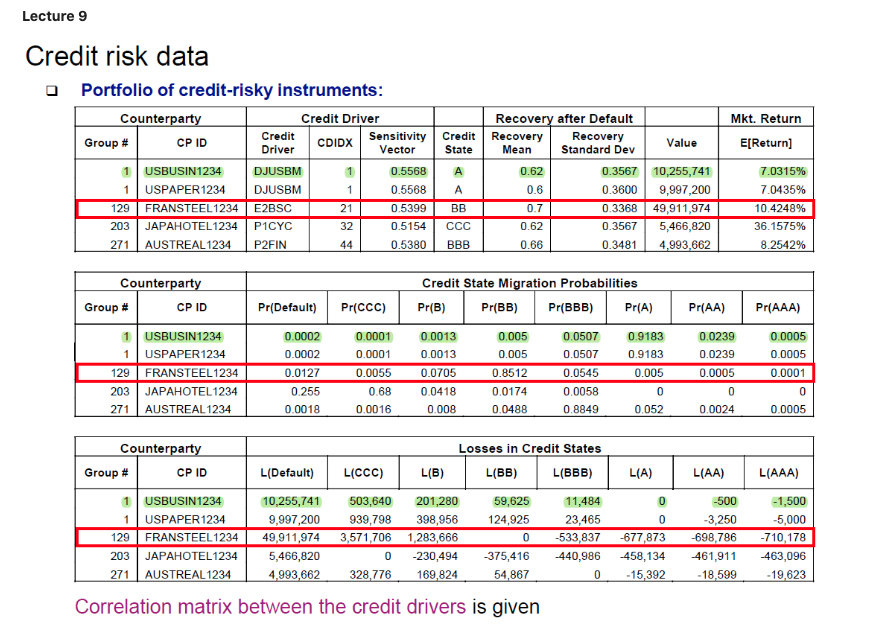

In losses, the postive number represents loss and negative number represents earning.

# Correlation Matrix between Credit Drivers

In [8]:
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))

In [9]:
rho

array([[1.        , 0.71330043, 0.54867614, ..., 0.52680428, 0.69384599,
        0.43595835],
       [0.71330043, 1.        , 0.27764869, ..., 0.64605875, 0.64742997,
        0.35453859],
       [0.54867614, 0.27764869, 1.        , ..., 0.29504695, 0.49383704,
        0.38201147],
       ...,
       [0.52680428, 0.64605875, 0.29504695, ..., 1.        , 0.60296195,
        0.48291409],
       [0.69384599, 0.64742997, 0.49383704, ..., 0.60296195, 1.        ,
        0.65331578],
       [0.43595835, 0.35453859, 0.38201147, ..., 0.48291409, 0.65331578,
        1.        ]])

In [10]:
rho.shape

(50, 50)

In [11]:
df2 = pd.DataFrame(rho)
print(df2.shape)
df2.head()

(50, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.713300,0.548676,0.705165,0.418110,0.810684,0.630473,0.635272,0.531261,0.343474,...,0.758481,0.705462,0.575063,0.610816,0.529302,0.639856,0.669646,0.526804,0.693846,0.435958
1,0.713300,1.000000,0.277649,0.788661,0.582775,0.837845,0.720812,0.791807,0.662415,0.380681,...,0.456648,0.749893,0.308538,0.592552,0.498712,0.598322,0.576893,0.646059,0.647430,0.354539
2,0.548676,0.277649,1.000000,0.286544,0.237641,0.400468,0.393283,0.292561,0.381162,0.581721,...,0.572147,0.530130,0.718659,0.430241,0.439439,0.447410,0.348778,0.295047,0.493837,0.382011
3,0.705165,0.788661,0.286544,1.000000,0.603727,0.771405,0.722944,0.765589,0.688625,0.533936,...,0.485105,0.731500,0.363420,0.719665,0.534505,0.703548,0.680683,0.647498,0.758259,0.479592
4,0.418110,0.582775,0.237641,0.603727,1.000000,0.574791,0.603756,0.603563,0.656759,0.401192,...,0.253235,0.516454,0.229859,0.396567,0.344604,0.462720,0.355504,0.483952,0.544184,0.286198


In [12]:
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

In [13]:
df3 = pd.DataFrame(sqrt_rho)
print(df3.shape)
df3.head()

(50, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.713300,0.700858,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.548676,-0.162261,0.820138,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705165,0.407594,-0.041733,0.578677,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.418110,0.405983,0.090362,0.254348,0.766488,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Credit-State & Losses

In [14]:
# Find the current credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

In [15]:
CS

array([6, 6, 4, 4, 5, 5, 5, 6, 7, 3, 4, 4, 5, 5, 5, 6, 4, 5, 6, 4, 5, 6,
       5, 6, 7, 8, 4, 4, 5, 5, 6, 4, 5, 2, 5, 7, 6, 5, 6, 5, 6, 4, 5, 5,
       5, 5, 4, 5, 5, 6, 6, 3, 4, 5, 2, 7, 4, 4, 5, 5, 6, 4, 5, 3, 5, 2,
       6, 6, 3, 4, 5, 5, 5, 6, 5, 6, 2, 6, 5, 4, 5, 3, 5, 4, 6, 6, 7, 5,
       8, 4, 6, 8, 5, 4, 4, 7, 5, 4, 5, 5])

In [16]:
print(prob[0,:])
print(prob[2,:])


[2.000e-04 1.000e-04 1.300e-03 5.000e-03 5.070e-02 9.183e-01 2.390e-02
 5.000e-04]
[1.270e-02 5.500e-03 7.050e-02 8.512e-01 5.450e-02 5.000e-03 5.000e-04
 1.000e-04]


In [17]:
# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

In [18]:
df4 = pd.DataFrame(exposure)
df4.head()

,0,1,2,3,4,5,6,7
0,3897181.58,503640.0,201280.0,59625.0,11484.0,0.0,-500.0,-1500.0
1,3998880.00,939798.0,398956.0,124925.0,23465.0,0.0,-3250.0,-5000.0
2,597197.10,127827.0,49364.0,0.0,-22345.0,-28192.0,-29480.0,-29884.0
3,15760240.86,2820870.0,1006907.0,0.0,-405563.0,-496704.0,-517622.0,-523328.0
4,2298919.00,459148.0,188151.0,50840.0,0.0,-11759.0,-13387.0,-14264.0


In [19]:
# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [20]:
df5 = pd.DataFrame(CS_Bdry)
df5

,0,1,2,3,4,5,6
0,-3.540084,-3.431614,-2.947843,-2.478327,-1.577850,1.970335,3.290527
1,-3.540084,-3.431614,-2.947843,-2.478327,-1.577850,1.970335,3.290527
2,-2.235264,-2.092431,-1.348804,1.553935,2.536396,3.238880,3.719016
3,-2.235264,-2.092431,-1.348804,1.553935,2.536396,3.238880,3.719016
4,-2.911238,-2.706483,-2.276769,-1.553097,1.599093,2.758879,3.290527
...,...,...,...,...,...,...,...
95,-3.540084,-3.540084,-3.431614,-3.090232,-2.687449,-1.405745,2.266840
96,-2.911238,-2.706483,-2.276769,-1.553097,1.599093,2.758879,3.290527
97,-2.235264,-2.092431,-1.348804,1.553935,2.536396,3.238880,3.719016
98,-2.911238,-2.706483,-2.276769,-1.553097,1.599093,2.758879,3.290527


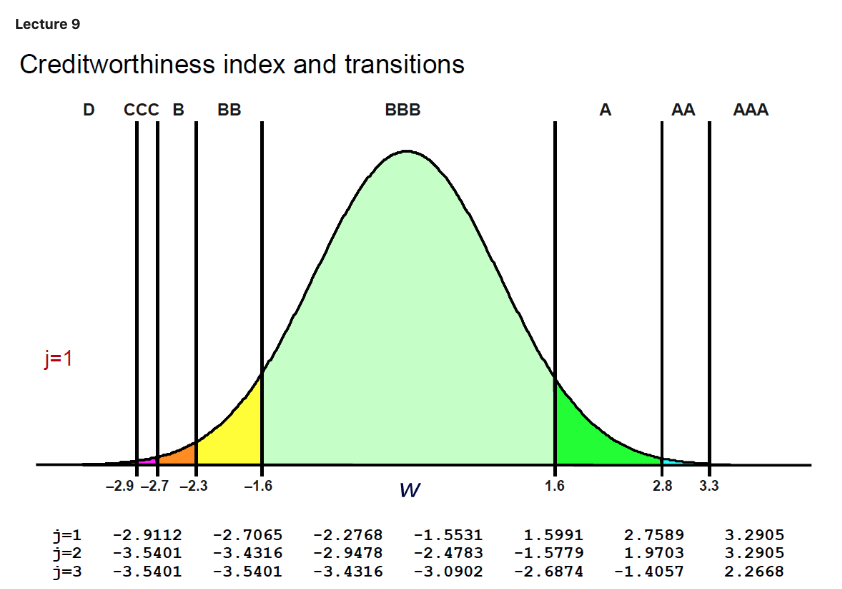

If B$_{BBB}$ $\leq$ W < B$_{A}$ then new credit state is BBB

In [21]:
np.cumsum(np.array([1,2,3,4]))

array([ 1,  3,  6, 10])

scipy.special.ndtri is used to return the argument x for which the area under the Gaussian probability density function is equal to y.

In [22]:
scipy.special.ndtri(0.95)

1.6448536269514722

In [23]:
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# Sparse Matrix (Optional for this Assignment)

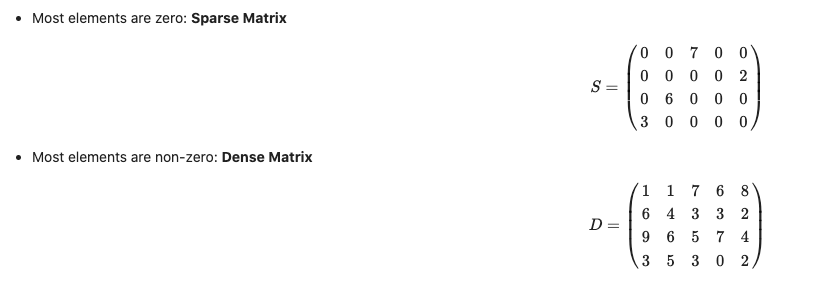

In [24]:
from sys import getsizeof
import os
density_matrix = np.zeros((10000,100))
density_matrix[3,17]=1
density_matrix[16,22]=2
density_matrix[20,21]=3
print(getsizeof(density_matrix)/1024/1024)

7.6295166015625


In [25]:
I = np.array([3,16,20])
J = np.array([17,22,21])
V = np.array([1,2,3])
shape = density_matrix.shape

In [26]:
# V is Value, (I,J) is the coordinate
sparse_matrix = scipy.sparse.csc_matrix((V,(I,J)),shape=shape)

In [27]:
print(sparse_matrix)

  (3, 17)	1
  (20, 21)	3
  (16, 22)	2


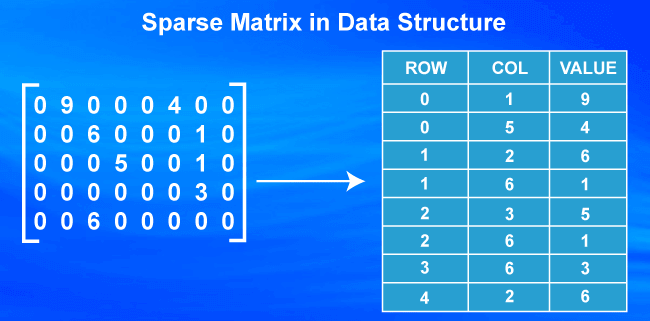

In [28]:
print(getsizeof(sparse_matrix)/1024/1024)

4.57763671875e-05


In [29]:
getsizeof(density_matrix)/getsizeof(sparse_matrix)

166669.33333333334

In [30]:
np.all(density_matrix==sparse_matrix.toarray())

True

In [31]:
np.savetxt("large_density_matrix.csv", density_matrix, delimiter=",")

In [32]:
f = open("large_density_matrix.csv")
# move file cursor to end
f.seek(0, os.SEEK_END)
# get the current cursor position
print('Size of file is', f.tell(), 'bytes')

Size of file is 25000000 bytes


In [33]:
Path('cool_sparse_matrix'+'.npz').is_file()

False

In [34]:
scipy.sparse.save_npz('cool_sparse_matrix' + '.npz', sparse_matrix)

In [35]:
Path('cool_sparse_matrix'+'.npz').is_file()

True

Note: this is just a way to express the matrix.  

# Hints

In [ ]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1
# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]
# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))
# -------- Insert your code here -------- #
"""
What's the dim of y? (Using sqrt_rho size)
What's y? (using np.dot(sqrt_rho,?))
What's volatility? 
See lecture 9 page 11
The values in Losses_out are from exposure, you need to find the correct index
"""
if Path(filename_save_out+’.npz’).is_file():
  Losses_out = scipy.sparse.load_npz(filename_save_out + ’.npz’)
else:
  # Generating Scenarios
  # -------- Insert your code here -------- #
  for s in range(1, Nout + 1):
      # -------- Insert your code here -------- #
      # Calculated the creditworthiness index (W)
      # Calculated out-of-sample losses (100000 x 100)
      # Losses_out (sparse matrix)
      Losses_out = #...

See TUT slides, page 5

In [ ]:
for portN in range(2):
  # Compute VaR and CVaR
  for q in range(alphas.size):
    alf = alphas[q]
    # -------- Insert your code here -------- #
    VaRout[portN, q] = #... Red Box 1
    VaRinN[portN, q] = #... Blue Box 1
    CVaRout[portN, q] = #... Red Box 2
    CVaRinN[portN, q] = #... Blue Box 2

Note : MC1 has one more level of for loop than MC2.

For the code, please follow your code in "Generating Scenarios" part. 

In [ ]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #


    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios <-- 1000
        # -------- Insert your code here -------- #

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic <-- 5
            # -------- Insert your code here -------- #

    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #


    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic) <-- 5000
        # -------- Insert your code here -------- #

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2


Compute VaR and CVaR

In [ ]:


    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = #... np.sort(?)
            portf_loss_inMC2 = #... np.sort(?)
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = #... np.dot(?)
            sigma_p_MC1 = #...
            mu_p_MC2 = #... np.dot(?)
            sigma_p_MC2 = #...
            """
            See Code for VaR & CVaR in TUT or example in Python in Lecture 8
            """
            VaRinMC1[portN, q][tr - 1] = #...
            VaRinMC2[portN, q][tr - 1] = #...
            VaRinN1[portN, q][tr - 1] =  #...
            VaRinN2[portN, q][tr - 1] =  #...
            CVaRinMC1[portN, q][tr - 1] = #...
            CVaRinMC2[portN, q][tr - 1] = #...
            CVaRinN1[portN, q][tr - 1] =  #...
            CVaRinN2[portN, q][tr - 1] =  #...

Key Plots Sample (the shape is just an example)





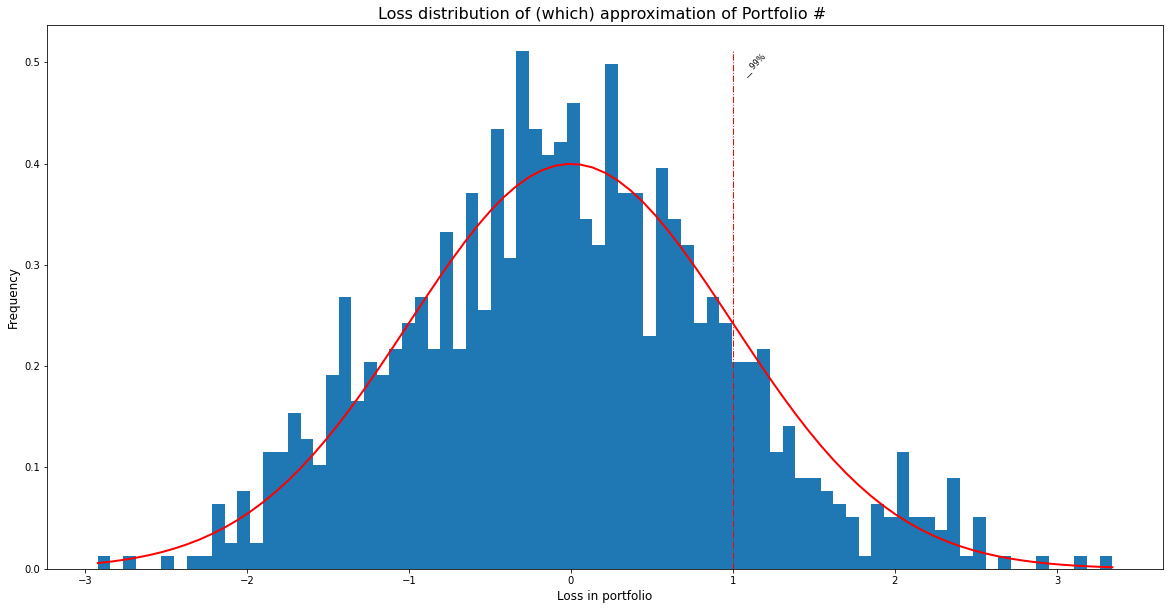

In [50]:
#from posixpath import normpath
fig = plt.figure(figsize=(20,10))
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 80, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, linewidth=2, color='r')
plt.plot([1,1],[0,max(count)],color='r',linewidth=1,linestyle='-.')
plt.text(1.05*1, max(count)/1.05, '__ 99%',fontsize=8, rotation=45)
"""
plot other lines, you can check example 2 in Python in Lecture 8
"""
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of (which) approximation of Portfolio # ',fontsize=16)
plt.show()